# Non-Periodic Data: Trying a Subharmonic Grid (SHG)

Author: Jacob Burba

## Background

**Instead of doing a standard FFT (or DFT) with a minimum delay of $\tau=\Delta\tau=1/B$ where $B$ is the bandwidth of the data, can we instead implement a subharmonic grid (SHG) for delay modes with wavelengths longer than the bandwidth?**

In a standard FFT, the resolution in delay space is $\Delta\tau = 1/B$ where $B=N_\nu\Delta\nu$ is the bandwidth of the data with $N_\nu$ frequencies and a frequency resolution of $\Delta\nu$.  The minimum delay in the standard FFT is thus $|\tau| = 1/B$.  The FFT transforms $N_\nu$ data points to $N_\rm{FFT}=N_\nu$ delay modes.  The subharmonic grid (SHG) introduces additional delay modes in between $\tau=0$ and $|\tau|=1/B$, i.e. contains Fourier modes with wavelengths longer than the bandwidth (with $0<|\tau|<1/B$).  These SHG modes can be spaced uniformly or non-uniformly depending upon the modes of interest.  In the tests in this notebook I have tried uniform and logarithmically spaced SHG modes and seen no difference in the results when using modes with wavelengths ranging from 1.5 to 15 times the bandwidth.

To test the SHG's effectiveness at modelling non-periodic data, I constructed mock data from a known delay power spectrum and looked at how well the SHG aids in recovering the input power spectrum when the data are non-periodic.  To start, I defined a "true" delay power spectrum
$$ P_{\rm{true}}(\tau) = 1 + 304.5\exp\left[ -\frac{\tau^2}{2\,(100\ \rm{ns})^2} \right] $$
This power spectrum is defined at the standard FFT delay modes and the $N_\rm{SHG}$ subharmonic grid modes and is plotted as the solid black line in the power spectrum comparison figure.  I defined a delay-space covariance matrix using this power spectrum as
$$ \mathbf{C}^{\tau\tau'}_\rm{FFT+SHG} = P_\rm{true}(\tau)\delta_{\tau\tau'} $$
by placing this power spectrum along the diagonal of a matrix with shape $(N_\nu+N_\rm{SHG}, N_\nu+N_\rm{SHG})$.  I then constructed a forward DFT matrix (transforming from frequency to delay space) which includes the FFT and SHG delay modes, $F_\rm{wSHG}$, with shape$^1$ $(N_\nu+N_\rm{SHG}, N_\nu)$ and entries
$$ F_\rm{wSHG}^{\tau\nu} = \exp\left[ -2\pi i \tau\nu \right] $$
Using this matrix, I calculated a frequency space covariance matrix with shape $(N_\nu, N_\nu)$ via
$$ \mathbf{C}^{\nu\nu'}_\rm{wSHG} = \frac{1}{(N_\nu+N_\rm{SHG})^2}\mathbf{F}_\rm{wSHG}^\dagger\mathbf{C}^{\tau\tau'}_\rm{FFT+SHG}\mathbf{F}_\rm{wSHG} $$
I then drew 1000 samples from a Gaussian distribution with zero mean and the above covariance to get my mock data 
$$ \boldsymbol{d} = \mathcal{N} \left( \boldsymbol{0}, \mathbf{C}^{\nu\nu'}_\rm{wSHG} \right) $$
This data is non-periodic over the bandwidth as it was constructed from the input power spectrum with non-zero power at the SHG delays.  Using $F_\rm{wSHG}$, I DFT'd this mock data to FFT+SHG delay space and computed it's power spectrum via
$$ \hat{P}_\rm{wSHG}(\tau) = \left| \mathbf{F}_\rm{wSHG}\boldsymbol{d} \right|^2 $$
This power spectrum is plotted as the red data points in the power spectrum comparison figure.

As a means of comparison, I also defined a square DFT matrix (mimicking the FFT), $\mathbf{F}_\rm{FFT}$, with shape $(N_\nu, N_\nu)$.  I similarly calculated a power spectrum from the non-periodic data using this standard DFT matrix
$$ \hat{P}_\rm{FFT}(\tau) = \left| \mathbf{F}_\rm{FFT}\boldsymbol{d} \right|^2 $$
This power spectrum is plotted as the dashed grey line in the power spectrum comparison figure.  I'll also note that I have checked that the delay spectrum and delay power spectrum obtained using $\mathbf{F}_\rm{FFT}$ agree to numerical precision with `numpy.fft.fft` (see appendix B).

<br>

----------
$^1$: This transformation results in a non-square DFT matrix with shape $(N_\nu + N_{\rm{SHG}}, N_\nu)$ where $N_\nu$ is the number of frequencies in the data and $N_{\rm{SHG}}$ is the number of SHG modes.  It appears to be left invertible but not right invertible.  I'm not sure what the consequences are of this non-square transformation.

## Code

### Imports and function definitions

In [2]:
%matplotlib inline

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from astropy import units
from pyuvdata import UVData
from scipy.signal.windows import blackmanharris

from hydra_pspec.utils import fourier_operator
from hydra_pspec.pspec import covariance_from_pspec

%run ~/src/research/hydra/pspec/post-processing-funcs.py

In [91]:
def calc_frac_diff(
    x, y, x_lbound=None, x_ubound=None, y_lbound=None, y_ubound=None,
    delta_xl=None, delta_xu=None, delta_yl=None, delta_yu=None
):
    """
    Compute the fractional difference between x and y with/without errorbars.
    
    Computed as :math:`\frac{x}{y} - 1`, i.e. the fractional difference of
    :math:`x` relative to :math:`y`.
    
    Errorbars can be incorporated via either
    * Lower and upper bounds (both lower and upper bounds required)
    * Lower and upper errorbars (both lower and upper errorbars required)

    Parameters
    ----------
    x : array_like
        Numerator values with shape (Nx,).
    y : array_like
        Denominator values with the same form as `x`.
    x_lbound : array_like, optional
        Lower bound(s) of `x` with the same form as `x`.
    x_ubound : array_like, optional
        Upper bound(s) of `x` with the same form as `x`.
    y_lbound : array_like, optional
        Lower bound(s) of `y` with the same form as `y`.
    y_ubound : array_like, optional
        Upper bound(s) of `y` with the same form as `y`.
    delta_xl : array_like, optional
        Lower uncertainty on `x` with the same form as `x`.
    delta_xu : array_like, optional
        Upper uncertainty on `x` with the same form as `x`.
    delta_yl : array_like, optional
        Lower uncertainty on `y` with the same form as `y`.
    delta_yu : array_like, optional
        Upper uncertainty on `y` with the same form as `y`.

    Returns
    -------
    fd : np.ndarray
        Fractional difference.
    fd_err : np.ndarray
        `fd_err` is a two-dimensional array with shape (2, Nx) which
        contains the lower and upper uncertainties on the fractional
        difference in the 0th and 1st rows, respectively.  Only
        returned if `x` or `y` has associated errorbars.

    """
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    if not isinstance(y, np.ndarray):
        y = np.array(y)

    use_x_err = np.logical_or(
        x_lbound is not None and x_ubound is not None,
        delta_xl is not None and delta_xu is not None
    )
    use_y_err = np.logical_or(
        y_lbound is not None and y_ubound is not None,
        delta_yl is not None and delta_yu is not None
    )
    
    fd = x/y - 1
    
    if use_x_err or use_y_err:
        # 0 index: lower bound
        # 1 index: higher bound
        fd_err = np.zeros((2,) + fd.shape)

    if use_x_err:
        # Define x^{+/-} = x +/- \Delta x^{+/-} where
        # \Delta x^- = lower errorbar
        # \Delta x^+ = upper errorbar
        if x_lbound is not None and x_ubound is not None:
            if not isinstance(x_lbound, np.ndarray):
                x_lbound = np.array(x_lbound)
            if not isinstance(x_ubound, np.ndarray):
                x_ubound = np.array(x_ubound)
            # Calculate errorbars from bounds
            delta_xl = x - x_lbound
            delta_xu = x_ubound - x
        else:
            if not isinstance(delta_xl, np.ndarray):
                delta_xl = np.array(delta_xl)
            if not isinstance(delta_xu, np.ndarray):
                delta_xu = np.array(delta_xu)

    if use_y_err:
        # Define y^{+/-} = y +/- \Delta y^{+/-} where
        # \Delta y^- = lower errorbar
        # \Delta y^+ = upper errorbar
        if y_lbound is not None and y_ubound is not None:
            if not isinstance(y_lbound, np.ndarray):
                y_lbound = np.array(y_lbound)
            if not isinstance(y_ubound, np.ndarray):
                y_ubound = np.array(y_ubound)
            # Calculate errorbars from bounds
            delta_yl = y - y_lbound
            delta_yu = y_ubound - y
        else:
            if not isinstance(delta_yl, np.ndarray):
                delta_yl = np.array(delta_yl)
            if not isinstance(delta_yu, np.ndarray):
                delta_yu = np.array(delta_yu)

    if use_x_err and use_y_err:
        # Minimum fractional difference occurs at (x^-, y^+)
        fd_err[0] = x / y * (1 - (1 - delta_xl / x) / (1 + delta_yu / y))
        # Maximum fractional difference occurs at (x^+, y^-)
        fd_err[1] = x / y * ((1 + delta_xu / x) / np.abs(1 - delta_yl / y) - 1)
    elif use_x_err:
        # Minimum fractional difference occurs at x^-
        fd_err[0] = x / y * delta_xl / x
        # Maximum fractional difference occurs at x^+
        fd_err[1] = x / y * delta_xu / x
    elif use_y_err:
        # Minimum fractional difference occurs at y^+
        fd_err[0] = x / y * (1 - 1 / (1 + delta_yu / y))
        # Maximum fractional difference occurs at y^-
        fd_err[1] = x / y * (1 / (1 - delta_yl / y) - 1)
    
    if use_x_err or use_y_err:
        return fd, fd_err
    else:
        return fd

### Input parameters

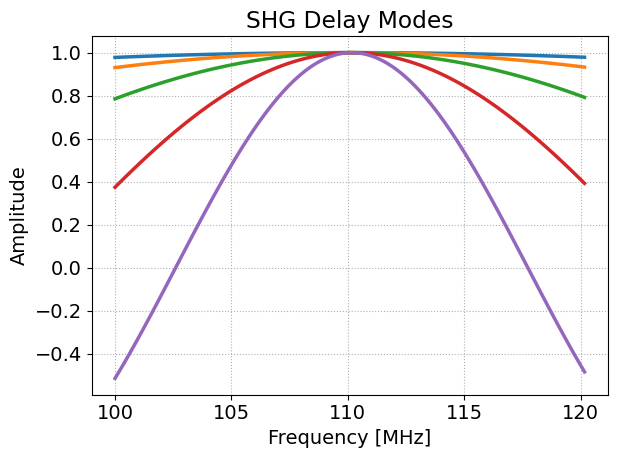

In [18]:
# Frequency params
# ----------------
# Chosen to match the simulations I ran for
# the FG modelling hydra-pspec paper
Nfreqs = 120
df = 169479.55652849376 * units.Hz
f_min = 100000000.0 * units.Hz

freqs = f_min + np.arange(Nfreqs)*df
extent_freq = (
    (freqs.min() - df/2).to('MHz').value,
    (freqs.max() + df/2).to('MHz').value
)


# Delay params
# ------------
delays = np.fft.fftshift(np.fft.fftfreq(Nfreqs, d=df.to('1/ns')))


# Subharmonic grid (SHG) params
# -----------------------------
# The bounds of the SHG modes are defined as fractional bandwidths.
# Values greater than 1 imply wavelengths longer than the bandwidth.
# max_bw_frac: longest fractional wavelength of SHG modes
# min_bw_frac: shortest fractional wavelength of SHG modes
# Nshg: number of SHG modes at positive delays.  The total number of
#       SHG modes is 2*Nshg to account for negative delays, too.
max_bw_frac = 15
min_bw_frac = 1.5
Nshg = 5

# Uniformly spaced SHG modes
# wavelengths_shg = np.linspace(max_bw_frac, min_bw_frac, Nshg) * np.ptp(freqs)
# Logarithmically spaced SHG modes
wavelengths_shg = freqs.unit * np.logspace(
    np.log10(max_bw_frac * np.ptp(freqs).value),
    np.log10(min_bw_frac * np.ptp(freqs).value),
    Nshg
)

# Delays of the SHG modes only
delays_shg = 1 / wavelengths_shg.to('1/ns')

# Mask for SHG modes in combined FFT+SHG delay space
delay_shg_mask = np.zeros(delays.size + Nshg*2, dtype=bool)
delay_shg_mask[(Nfreqs + 2*Nshg)//2 - Nshg : (Nfreqs + 2*Nshg)//2] = True
delay_shg_mask[(Nfreqs + 2*Nshg)//2 + 1 : (Nfreqs + 2*Nshg)//2 + 1 + Nshg] = True

# All delay modes (FFT + SHG)
delays_wshg = np.zeros(delays.size + Nshg*2) * units.ns
delays_wshg[delay_shg_mask] = np.concatenate((-delays_shg[::-1], delays_shg))
delays_wshg[~delay_shg_mask] = delays

# Figure showing the SHG modes
shg_modes = np.cos(
    2*np.pi
    * (freqs - freqs[Nfreqs//2]).to('1/s').value[:, None]
    * delays_shg.to('s').value[None, :]
)
fig, ax = plt.subplots()
ax.plot(freqs.to('MHz'), shg_modes)
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('Amplitude')
ax.set_title('SHG Delay Modes')
ax.grid()
fig.tight_layout()


# Fourier transform matrices
# --------------------------
# Standard DFT matrix (equivalent to np.fft.fft)
F_dft = fourier_operator(Nfreqs)
# Equivalent definition to show similarity to F_wshg defined below
# F_dft = np.exp(
#     -2*np.pi*1j
#     * delays.to('s').value.reshape(-1, 1),
#     * (freqs - freqs[Nfreqs//2]).to('1/s').value.reshape(1, -1)
# )

# DFT matrix using combined FFT and SHG modes
F_wshg = np.exp(
    -2*np.pi*1j
    * delays_wshg.to('s').value.reshape(-1, 1)
    * (freqs - freqs[Nfreqs//2]).to('1/s').value.reshape(1, -1)
)

**Figure 1:** SHG delay modes plotted as a function of frequency.

### Mock data generation

In [95]:
# Form analytic delay power spectrum
dps_true = 1 + 304.5 * np.exp(-(delays_wshg.value)**2 / (2 * 100**2))
cov_true_delay = np.diag(dps_true)
cov_true_circ = (F_wshg.conj().T @ cov_true_delay @ F_wshg).real / delays_wshg.size**2
# Uncomment these lines to test good recovery when ignorning SHG scales (passed)
# dps_true = 1 + 304.5 * np.exp(-(delays.value)**2 / (2 * 100**2))
# cov_true_delay = np.diag(dps_true)
# cov_true_circ = (F_dft.conj().T @ cov_true_delay @ F_dft).real / delays.size**2

# Construct mock data as draws from a Normal distribution with
# zero mean and covariance `cov_true_circ`
Ndraws = 1000
generator = np.random.Generator(np.random.PCG64(seed=420))
data = generator.multivariate_normal(np.zeros(Nfreqs), cov_true_circ, size=Ndraws)

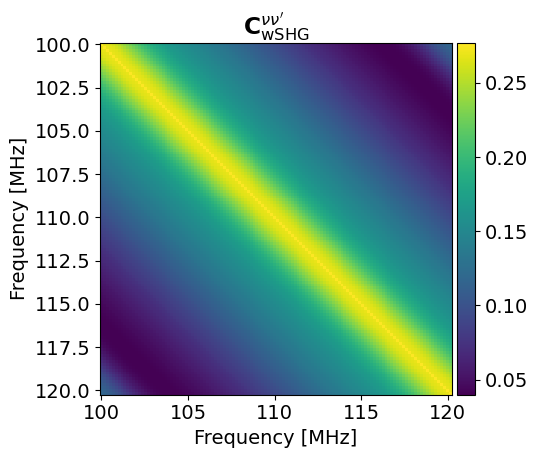

In [96]:
# Figure showing the freq-freq covariance matrix of the input delay power spectrum
fig, ax = plt.subplots()
im = ax.imshow(cov_true_circ.real, extent=extent_freq+extent_freq[::-1])
fig.colorbar(im, ax=ax, pad=0.01)
ax.set_title(r"$\mathbf{C}_{\rm{wSHG}}^{\nu\nu'}$")
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('Frequency [MHz]')
fig.tight_layout();

**Figure 2:** Frequency-frequency covariance matrix $\mathbf{C}_{\rm{wSHG}}^{\nu\nu'}$.

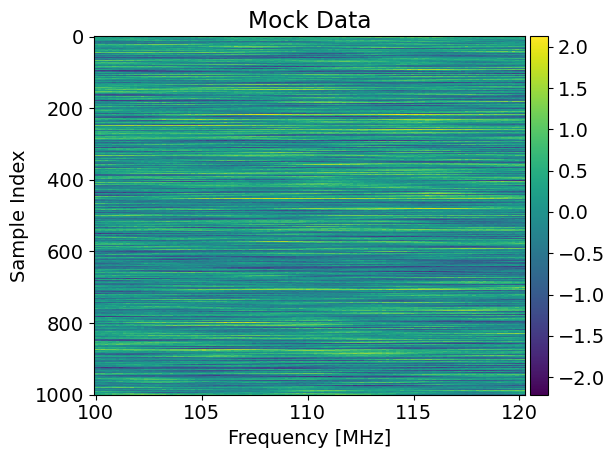

In [97]:
# Figure showing the mock data
fig, ax = plt.subplots()
im = ax.imshow(data, extent=extent_freq+(Ndraws+0.1, -0.5), aspect='auto')
fig.colorbar(im, ax=ax, pad=0.01)
ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('Sample Index')
ax.set_title('Mock Data')
fig.tight_layout();

**Figure 3:** Mock data drawn from a normal distribution $\mathcal{N}(\boldsymbol{0}, \mathbf{C}_{\rm{wSHG}}^{\nu\nu'})$.  The y axis indexes the sample axis.  1000 samples were drawn from this distribution to form the mock data.

### Delay power spectrum estimation

In [98]:
# Fourier transform to delay space
if len(vis.shape) == 2:
    ds_dft = (F_dft @ data.T).T
    ds_wshg = (F_wshg @ data.T).T
else:
    ds_dft = F_dft @ data
    ds_wshg = F_wshg @ data
# Compute delay power spectra
dps_dft = np.abs(ds_dft)**2
dps_wshg = np.abs(ds_wshg)**2
# Sample means
dps_dft_mean = dps_dft.mean(axis=0)
dps_wshg_mean = dps_wshg.mean(axis=0)
# 95% confidence intervals over the sample axis
percentile = 95/2 + 50
dps_dft_ci = np.vstack((
    np.percentile(dps_dft, 100-percentile, axis=0),
    np.percentile(dps_dft, percentile, axis=0)
))
dps_dft_err = (
    dps_dft_mean - dps_dft_ci[0],
    dps_dft_ci[1] - dps_dft_mean
)
dps_wshg_ci = np.vstack((
    np.percentile(dps_wshg, 100-percentile, axis=0),
    np.percentile(dps_wshg, percentile, axis=0)
))
dps_wshg_err = (
    dps_wshg_mean - dps_wshg_ci[0],
    dps_wshg_ci[1] - dps_wshg_mean
)

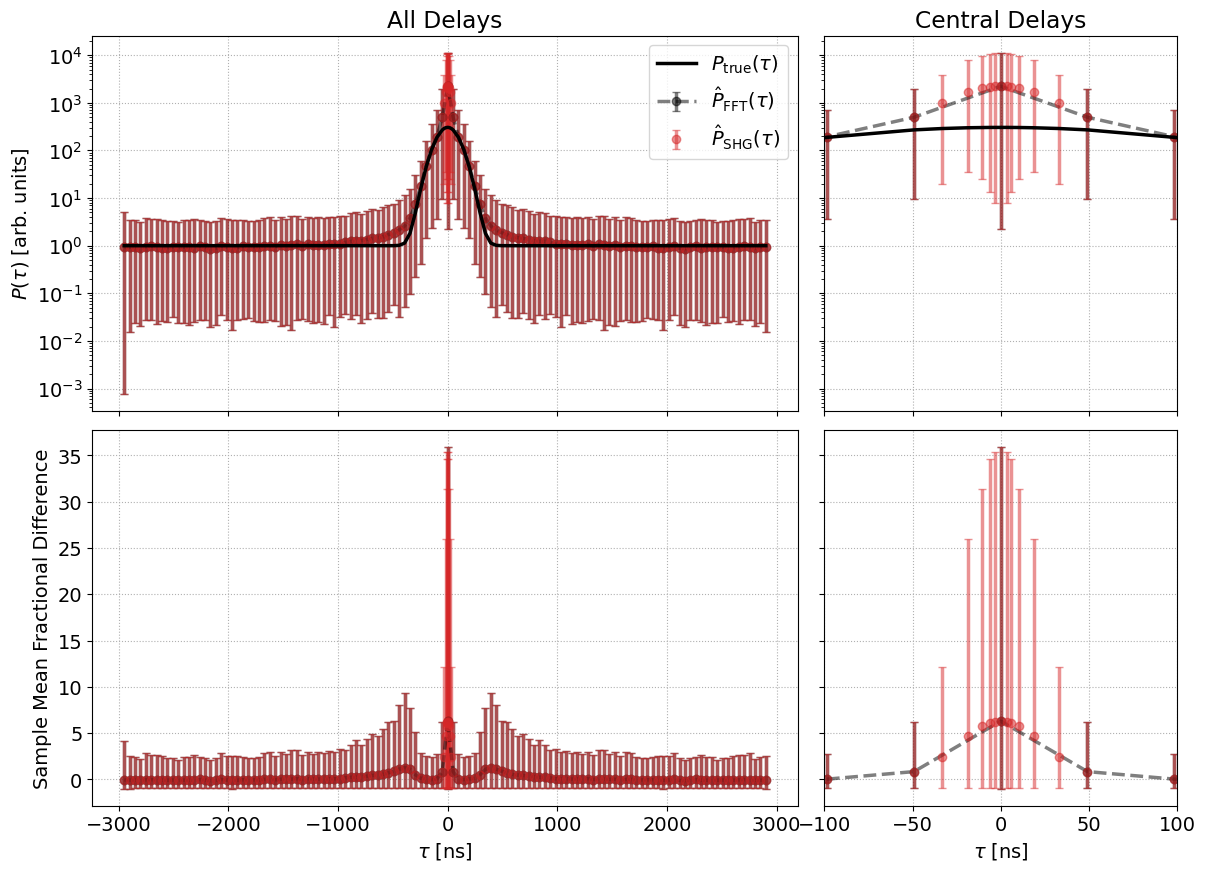

In [99]:
# Delay power spectrum comparison figure
fig, axs = plt.subplots(
    2, 2, sharex=False, figsize=(14, 10),
    gridspec_kw={'hspace': 0.05, 'wspace': 0.05, 'width_ratios': [2, 1]}
)
xlims = [None, (-100, 100)]
for i_col, xlim in enumerate(xlims):
    ax = axs[0, i_col]
    if i_col == 0:
        ax.set_ylabel(r'$P(\tau)$ [arb. units]')
        ax.set_title('All Delays')
    else:
        ax.set_title('Central Delays')
    ax.plot(
        delays_wshg, dps_true, color='k', zorder=5,
        label=r'$P_{\rm{true}}(\tau)$'
    )
    ax.errorbar(
        delays, dps_dft_mean, yerr=dps_dft_err,
        ls='--', marker='o', color='k', alpha=0.5, capsize=3,
        label=r'$\hat{P}_{\rm{FFT}}(\tau)$'
    )
    ax.errorbar(
        delays_wshg, dps_wshg_mean, yerr=dps_wshg_err,
        ls='', marker='o', color='C3', alpha=0.5, capsize=3,
        label=r'$\hat{P}_{\rm{SHG}}(\tau)$'
    )
    ax.set_yscale('log')
    if i_col == 0:
        ax.legend()
        ylim_ps = ax.get_ylim()
    else:
        ax.set_ylim(ylim_ps)
        ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(xlim)
    
    ax = axs[1, i_col]
    ax.set_xlabel(r'$\tau$ [ns]')
    if i_col == 0:
        ax.set_ylabel('Sample Mean Fractional Difference')
    fd_dft, fd_dft_err = calc_frac_diff(
        dps_dft_mean,
        dps_true[~delay_shg_mask],
        x_lbound=dps_dft_ci[0],
        x_ubound=dps_dft_ci[1]
    )
    ax.errorbar(
        delays, fd_dft, yerr=fd_dft_err,
        ls='--', marker='o', color='k', alpha=0.5, capsize=3
    )
    fd_wshg, fd_wshg_err = calc_frac_diff(
        dps_wshg_mean,
        dps_true,
        x_lbound=dps_wshg_ci[0],
        x_ubound=dps_wshg_ci[1]
    )
    ax.errorbar(
        delays_wshg, fd_wshg, yerr=fd_wshg_err,
        ls='', marker='o', color='C3', alpha=0.5, capsize=3
    )
    if i_col == 0:
        ylim_fd = ax.get_ylim()
    else:
        ax.set_ylim(ylim_fd)
        ax.set_yticklabels([])
    ax.set_xlim(xlim)

for ax in axs.flatten():
    ax.grid()

**Figure 1:** (Top left) Delay power spectra (DPS) for the "true" input DPS (black line), mock data using the standard FFT delays (grey), and mock data using the standard FFT and SHG delays (red).  The errorbars correspond to the 95% confidence interval over the sample axis. (Bottom left) Fractional difference of the grey and red data relative to the black line (i.e. $\hat{P}/P - 1$).  The right subplots display the same data but are zoomed in on the delay axis to showcase the SHG modes.

## Appendix A: Non-square DFT matrix inverse check

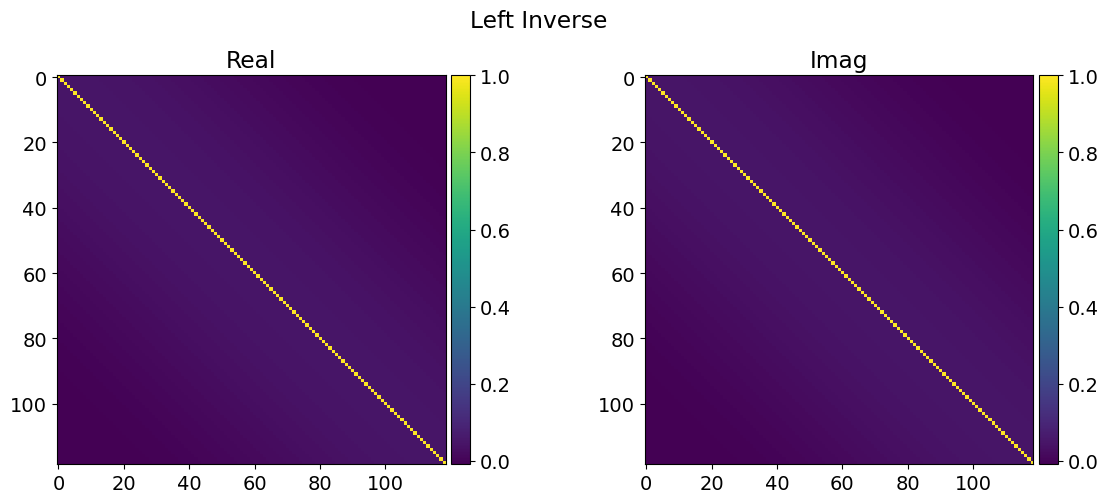

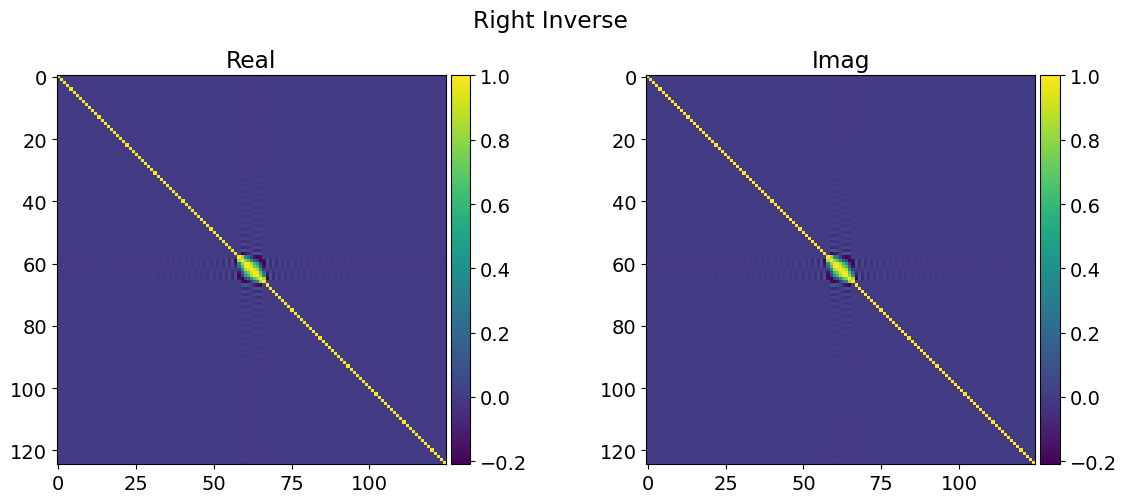

In [134]:
leftinv = F_wshg.conjugate().T @ F_wshg / delays_wshg.size
rightinv = F_wshg @ F_wshg.conjugate().T / Nfreqs

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Left Inverse')

ax = axs[0]
ax.set_title('Real')
im = ax.imshow(leftinv.real)
cb = fig.colorbar(im, ax=ax, pad=0.01)

ax = axs[1]
ax.set_title('Imag')
im = ax.imshow(leftinv.real)
cb = fig.colorbar(im, ax=ax, pad=0.01)

fig.tight_layout()


fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Right Inverse')

ax = axs[0]
ax.set_title('Real')
im = ax.imshow(rightinv.real)
cb = fig.colorbar(im, ax=ax, pad=0.01)

ax = axs[1]
ax.set_title('Imag')
im = ax.imshow(rightinv.real)
cb = fig.colorbar(im, ax=ax, pad=0.01)

fig.tight_layout()

I think this makes sense given that the number of delays is greater than the number of frequencies.  I think I'd expect the SHG modes to be correlated with one another because we have fewer data points in frequency space than we get in delay space with the non-square DFT.

## Appendix B: DFT vs FFT check

Text(0.5, 0.98, 'DFT vs FFT Comparison Summary')

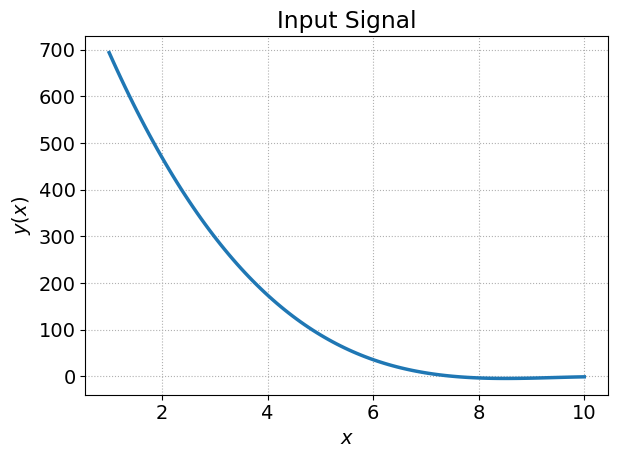

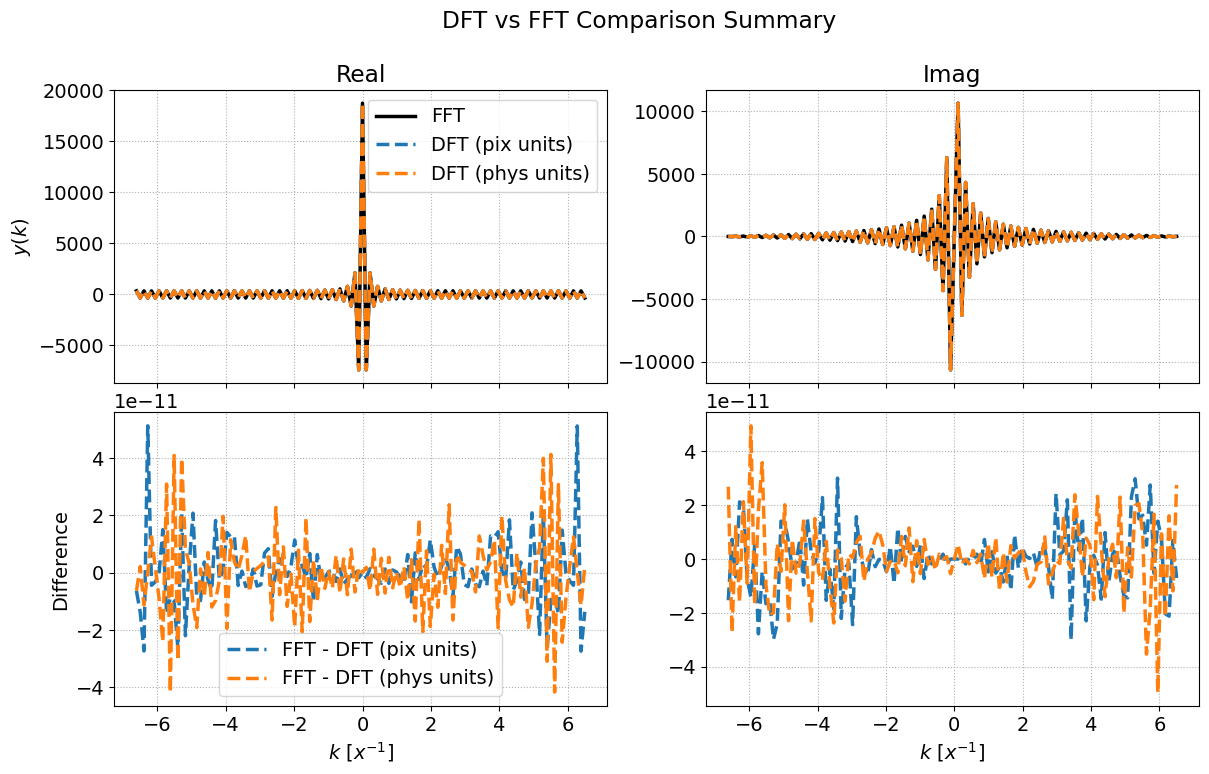

In [102]:
xs = np.linspace(1, 10, 120)
ys = -1.2*(xs - 10)**3 - 2*(xs - 10)**2 + 2*(xs - 10) - 1

fig, ax = plt.subplots()
ax.set_title('Input Signal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y(x)$')
ax.plot(xs, ys)
ax.grid()
fig.tight_layout()

ks = np.fft.fftshift(np.fft.fftfreq(xs.size, d=np.diff(xs).mean()))
ys_fft = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(ys)))

# DFT matrix in pixel units
xs_pix = np.arange(xs.size) - xs.size//2
ks_pix = np.arange(ks.size) - ks.size//2
dft_mat_pix = np.exp(
    -2 * np.pi * 1j
    * (ks_pix.reshape(-1, 1) * xs_pix.reshape(1, -1)) / xs.size
)
ys_dft_pix = dft_mat_pix @ ys

# DFT matrix in physical units
dft_mat_phys = np.exp(
    -2 * np.pi * 1j
    * ks.reshape(-1, 1)
    * (xs - xs[xs.size//2]).reshape(1, -1)
)
ys_dft_phys = dft_mat_phys @ ys

# Compare Fourier transforms
fig, axs = plt.subplots(
    2, 2, figsize=(14, 8), sharex=True, gridspec_kw={'hspace': 0.1}
)

ax = axs[0, 0]
ax.set_title('Real')
ax.set_ylabel(r'$y(k)$')
ax.plot(ks, ys_fft.real, 'k', label='FFT')
ax.plot(ks, ys_dft_pix.real, '--', label='DFT (pix units)')
ax.plot(ks, ys_dft_phys.real, '--', label='DFT (phys units)')
ax.legend()

ax = axs[1, 0]
ax.set_ylabel('Difference')
ax.set_xlabel(r'$k$ [$x^{-1}$]')
ax.plot(ks, ys_fft.real - ys_dft_pix.real, '--', label='FFT - DFT (pix units)')
ax.plot(ks, ys_fft.real - ys_dft_phys.real, '--', label='FFT - DFT (phys units)')
ax.legend()

ax = axs[0, 1]
ax.set_title('Imag')
ax.plot(ks, ys_fft.imag, 'k')
ax.plot(ks, ys_dft_pix.imag, '--')
ax.plot(ks, ys_dft_phys.imag, '--')

ax = axs[1, 1]
ax.set_xlabel(r'$k$ [$x^{-1}$]')
ax.plot(ks, ys_fft.imag - ys_dft_pix.imag, '--')
ax.plot(ks, ys_fft.imag - ys_dft_phys.imag, '--')

for ax in axs.flatten():
    ax.grid()
fig.suptitle('DFT vs FFT Comparison Summary')

This comparison plot shows that the DFT formalism used to define the DFT matrices in this document agrees with the results from `numpy.fft.fft` (without the SHG).  The left and right columns compare the real and imaginary components of the Fourier transform, respectively.  The top and bottom columns show the Fourier transforms when using `numpy.fft.fft` (black), a DFT matrix using $x$ and $k$ in pixel units (blue), and a DFT matrix using $x$ and $k$ in physical (inverse) units (orange).  The unit comparison is irrelevant and was just done for my sanity :)